In [52]:
# Python
import os
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, Union, List

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Lambda, ToPILImage
import lightning as L

# HuggingFace
import datasets
import diffusers
from diffusers import DiffusionPipeline, ImagePipelineOutput

# Visualization
from tqdm.auto import tqdm
import PIL

In [ ]:
class DDPMPipeline_Conditional(DiffusionPipeline):
    """modified: https://github.com/huggingface/diffusers/blob/v0.3.0/src/diffusers/pipelines/ddpm/pipeline_ddpm.py"""

    def __init__(self, unet, scheduler):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(
        self,
        class_labels: List[int] = [0],
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        if "torch_device" in kwargs:
            device = kwargs.pop("torch_device")
            warnings.warn(
                "`torch_device` is deprecated as an input argument to `__call__` and will be removed in v0.3.0."
                " Consider using `pipe.to(torch_device)` instead."
            )

            # Set device as before (to be removed in 0.3.0)
            if device is None:
                device = "cuda" if torch.cuda.is_available() else "cpu"
            self.to(device)

        # Sample gaussian noise to begin loop
        image = torch.randn(
            (
                len(class_labels),
                self.unet.config.in_channels,
                self.unet.sample_size,
                self.unet.sample_size,
            ),
            generator=generator,
        )
        image = image.to(self.device)

        # set step values
        self.scheduler.set_timesteps(1000)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t, class_labels).sample

            # 2. compute previous image: x_t -> t_t-1
            image = self.scheduler.step(
                model_output, t, image, generator=generator
            ).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

In [ ]:
class LightningDiffusion(L.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.config = config

        # define up and down blocks for unet,
        # e.g. block_out_channels = (64, 128, 256, 256) and num_attn_blocks = 1
        # -> ['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D']
        # -> ['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D']
        down_blocks = [
            "AttnDownBlock2D" if blk < config.num_attn_blocks else "DownBlock2D"
            for blk in reversed(range(len(config.block_out_channels)))
        ]

        up_blocks = [
            "AttnUpBlock2D" if blk < config.num_attn_blocks else "UpBlock2D"
            for blk in range(len(config.block_out_channels))
        ]

        # define unet (2D = images)
        self.unet = diffusers.UNet2DModel(
            sample_size=config.image_size,
            in_channels=config.image_channels,
            out_channels=config.image_channels,
            num_class_embeds=config.num_classes,
            layers_per_block=config.layers_per_block,
            block_out_channels=config.block_out_channels,
            down_block_types=down_blocks,
            up_block_types=up_blocks,
        )

        # define noise scheduler
        self.noise_scheduler = diffusers.DDPMScheduler(
            num_train_timesteps=config.num_train_timesteps
        )

    def configure_optimizers(self):
        # use Adam optimizer
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.config.learning_rate
        )

        # define learning rate scheduler: linear warmup with cosine decay
        scheduler = diffusers.optimization.get_scheduler(
            name="cosine",
            optimizer=optimizer,
            num_warmup_steps=self.config.lr_warmup_steps,
            num_training_steps=self.config.num_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # update lr-rate after every step instead of every epoch
            },
        }

    def forward(self, noisy_images, timesteps, labels):
        return self.unet(noisy_images, timesteps, labels)["sample"]

    def training_step(self, batch, batch_idx):
        clean_images, labels = batch["image"], batch["label"]
        batch_size = len(clean_images)
        device = clean_images.device

        # sample random noise
        noise = torch.randn(clean_images.shape).to(device)

        # get random timesteps
        timesteps = torch.randint(
            0, self.noise_scheduler.config.num_train_timesteps, (batch_size,)
        ).to(device)

        # add noise to images, depending on timestep
        noisy_images = self.noise_scheduler.add_noise(
            clean_images, noise, timesteps
        )

        # predict noise at given timesteps
        noise_pred = self(noisy_images, timesteps, labels)

        # evaluate loss function
        loss = F.mse_loss(noise_pred, noise)
        self.log("Loss", loss.item(), prog_bar=True)

        # log learning rate
        lr = trainer.lr_scheduler_configs[0].scheduler.get_last_lr()[0]
        self.log("lr", lr, prog_bar=True)

        return loss

    def sample(self, class_labels=[0], num_timesteps=50, seed=42, pbar=True):
        # create sampling pipeline
        pipeline = DDPMPipeline_Conditional(
            unet=self.unet, scheduler=self.noise_scheduler
        )
        pipeline.set_progress_bar_config(disable=not pbar)

        # sample images
        if num_timesteps is None:
            num_timesteps = self.config.num_sample_timesteps

        return pipeline(
            class_labels=torch.tensor(class_labels).to(self.device),
            num_inference_steps=num_timesteps,
            generator=torch.Generator(device="cpu").manual_seed(seed),
        )["images"]

    def on_train_epoch_end(self):
        n_cls = self.config.num_classes
        n_rows = 4

        # sample some images
        images = model.sample(
            class_labels=n_rows * list(range(n_cls)),
            num_timesteps=50,
            seed=self.config.seed,
            pbar=False,
        )

        # concat outputs and save as one jpg
        save_path = f"lightning_logs/version_{self.logger.version}/intermediate_results/"
        os.makedirs(save_path, exist_ok=True)

        image_grid = diffusers.utils.make_image_grid(
            images, rows=n_rows, cols=n_cls
        )
        image_grid.resize((n_cls * 64, n_rows * 64)).save(
            save_path + f"out_step-{self.global_step}.jpg"
        )

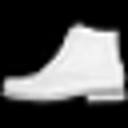

In [42]:
# prepare dataset
def transform(dataset):
    preprocess = Compose(
        [
            Resize((32, 32)),
            ToTensor(),
            Lambda(lambda x: 2 * (x - 0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"image": images, "label": dataset["label"]}


dataset = datasets.load_dataset("zalando-datasets/fashion_mnist", split="train")
dataset.set_transform(transform)

sample_image = dataset[42]["image"]
ToPILImage()(sample_image / 2 + 0.5).resize((128, 128))

In [62]:
@dataclass
class ModelConfig:
    image_size = dataset[0]["image"].shape[1]
    image_channels = dataset[0]["image"].shape[0]
    block_out_channels = (64, 128, 256, 256)
    num_attn_blocks = 3
    layers_per_block = 2
    class_emb_dim = 4
    num_classes = 10
    num_train_timesteps = 1000
    num_sample_timesteps = 50
    train_batch_size = 32
    eval_batch_size = 16
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    num_training_steps = (
        min(lr_warmup_steps, len(dataset) // train_batch_size) * num_epochs
    )
    mixed_precision = "bf16"
    seed = 0


config = ModelConfig()

In [64]:
# create model
model = LightningDiffusion(config)

# train model
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True
)

trainer = L.Trainer(
    max_epochs=config.num_epochs,
    precision=config.mixed_precision,
    limit_train_batches=config.lr_warmup_steps,
    gradient_clip_val=1.0,
    fast_dev_run=False,
)
trainer.fit(model, train_dataloader)

c:\Users\Gregor\miniforge3\envs\diffusion\lib\site-packages\lightning\fabric\connector.py:572: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params | Mode 
---------------------------------------------
0 | unet | UNet2DModel | 27.0 M | train
---------------------------------------------
27.0 M    Trainable params
0         Non-trainable params
27.0 M    Total params
107.821   Total estimated model params size (MB)
352       Modules in train mode
0         Modules in eval mode
c:\Users\Gregor\miniforge3\envs\diffusion\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consi

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Gregor\AppData\Local\Temp\ipykernel_17176\4012105812.py:33: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  self.unet.in_channels,
`Trainer.fit` stopped: `max_epochs=10` reached.


C:\Users\Gregor\AppData\Local\Temp\ipykernel_17176\4012105812.py:33: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  self.unet.in_channels,


  0%|          | 0/1000 [00:00<?, ?it/s]

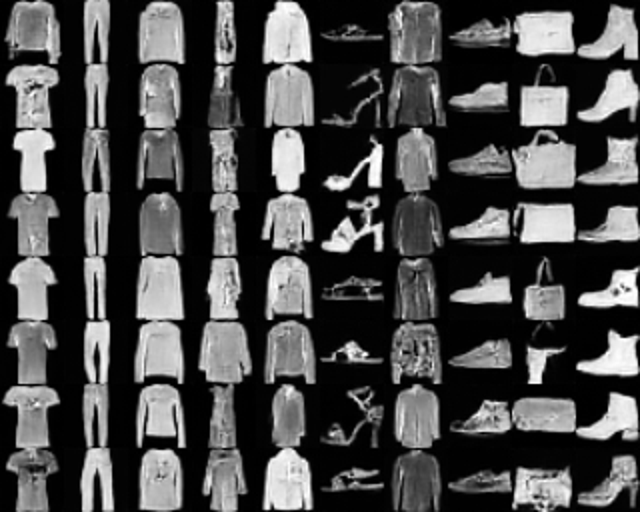

In [73]:
model.cuda()  # move to cuda
images = model.sample(
    class_labels=8 * list(range(10)),
    num_timesteps=1000,
    seed=np.random.randint(1e8),
)

diffusers.utils.make_image_grid(images, cols=10, rows=8).resize(
    (10 * 64, 8 * 64)
)